In [195]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [234]:
cancer = pd.read_csv('data.csv')

Для начала посмотрим, насколько у нас вообще сбалансированы классы для разного типа рака.

In [235]:
cancer.groupby('diagnosis').count()

id  radius_mean  texture_mean  perimeter_mean  area_mean  \
diagnosis                                                              
B          357          357           357             357        357   
M          212          212           212             212        212   

           smoothness_mean  compactness_mean  concavity_mean  \
diagnosis                                                      
B                      357               357             357   
M                      212               212             212   

           concave points_mean  symmetry_mean  ...  texture_worst  \
diagnosis                                      ...                  
B                          357            357  ...            357   
M                          212            212  ...            212   

           perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
diagnosis                                                                     
B                      357         357               357                357   
M                      212         212               212                212   

           concavity_worst  concave points_worst  symmetry_worst  \
diagnosis                                                          
B                      357                   357             357   
M                      212                   212             212   

           fractal_dimension_worst  Unnamed: 32  
diagnosis                                        
B                              357            0  
M                              212            0  

[2 rows x 32 columns]

Видим, что в целом классы довольно сильно не сбалансированы, так что может оказаться, что для предсказания класса 'B' модель может работать все же лучше.

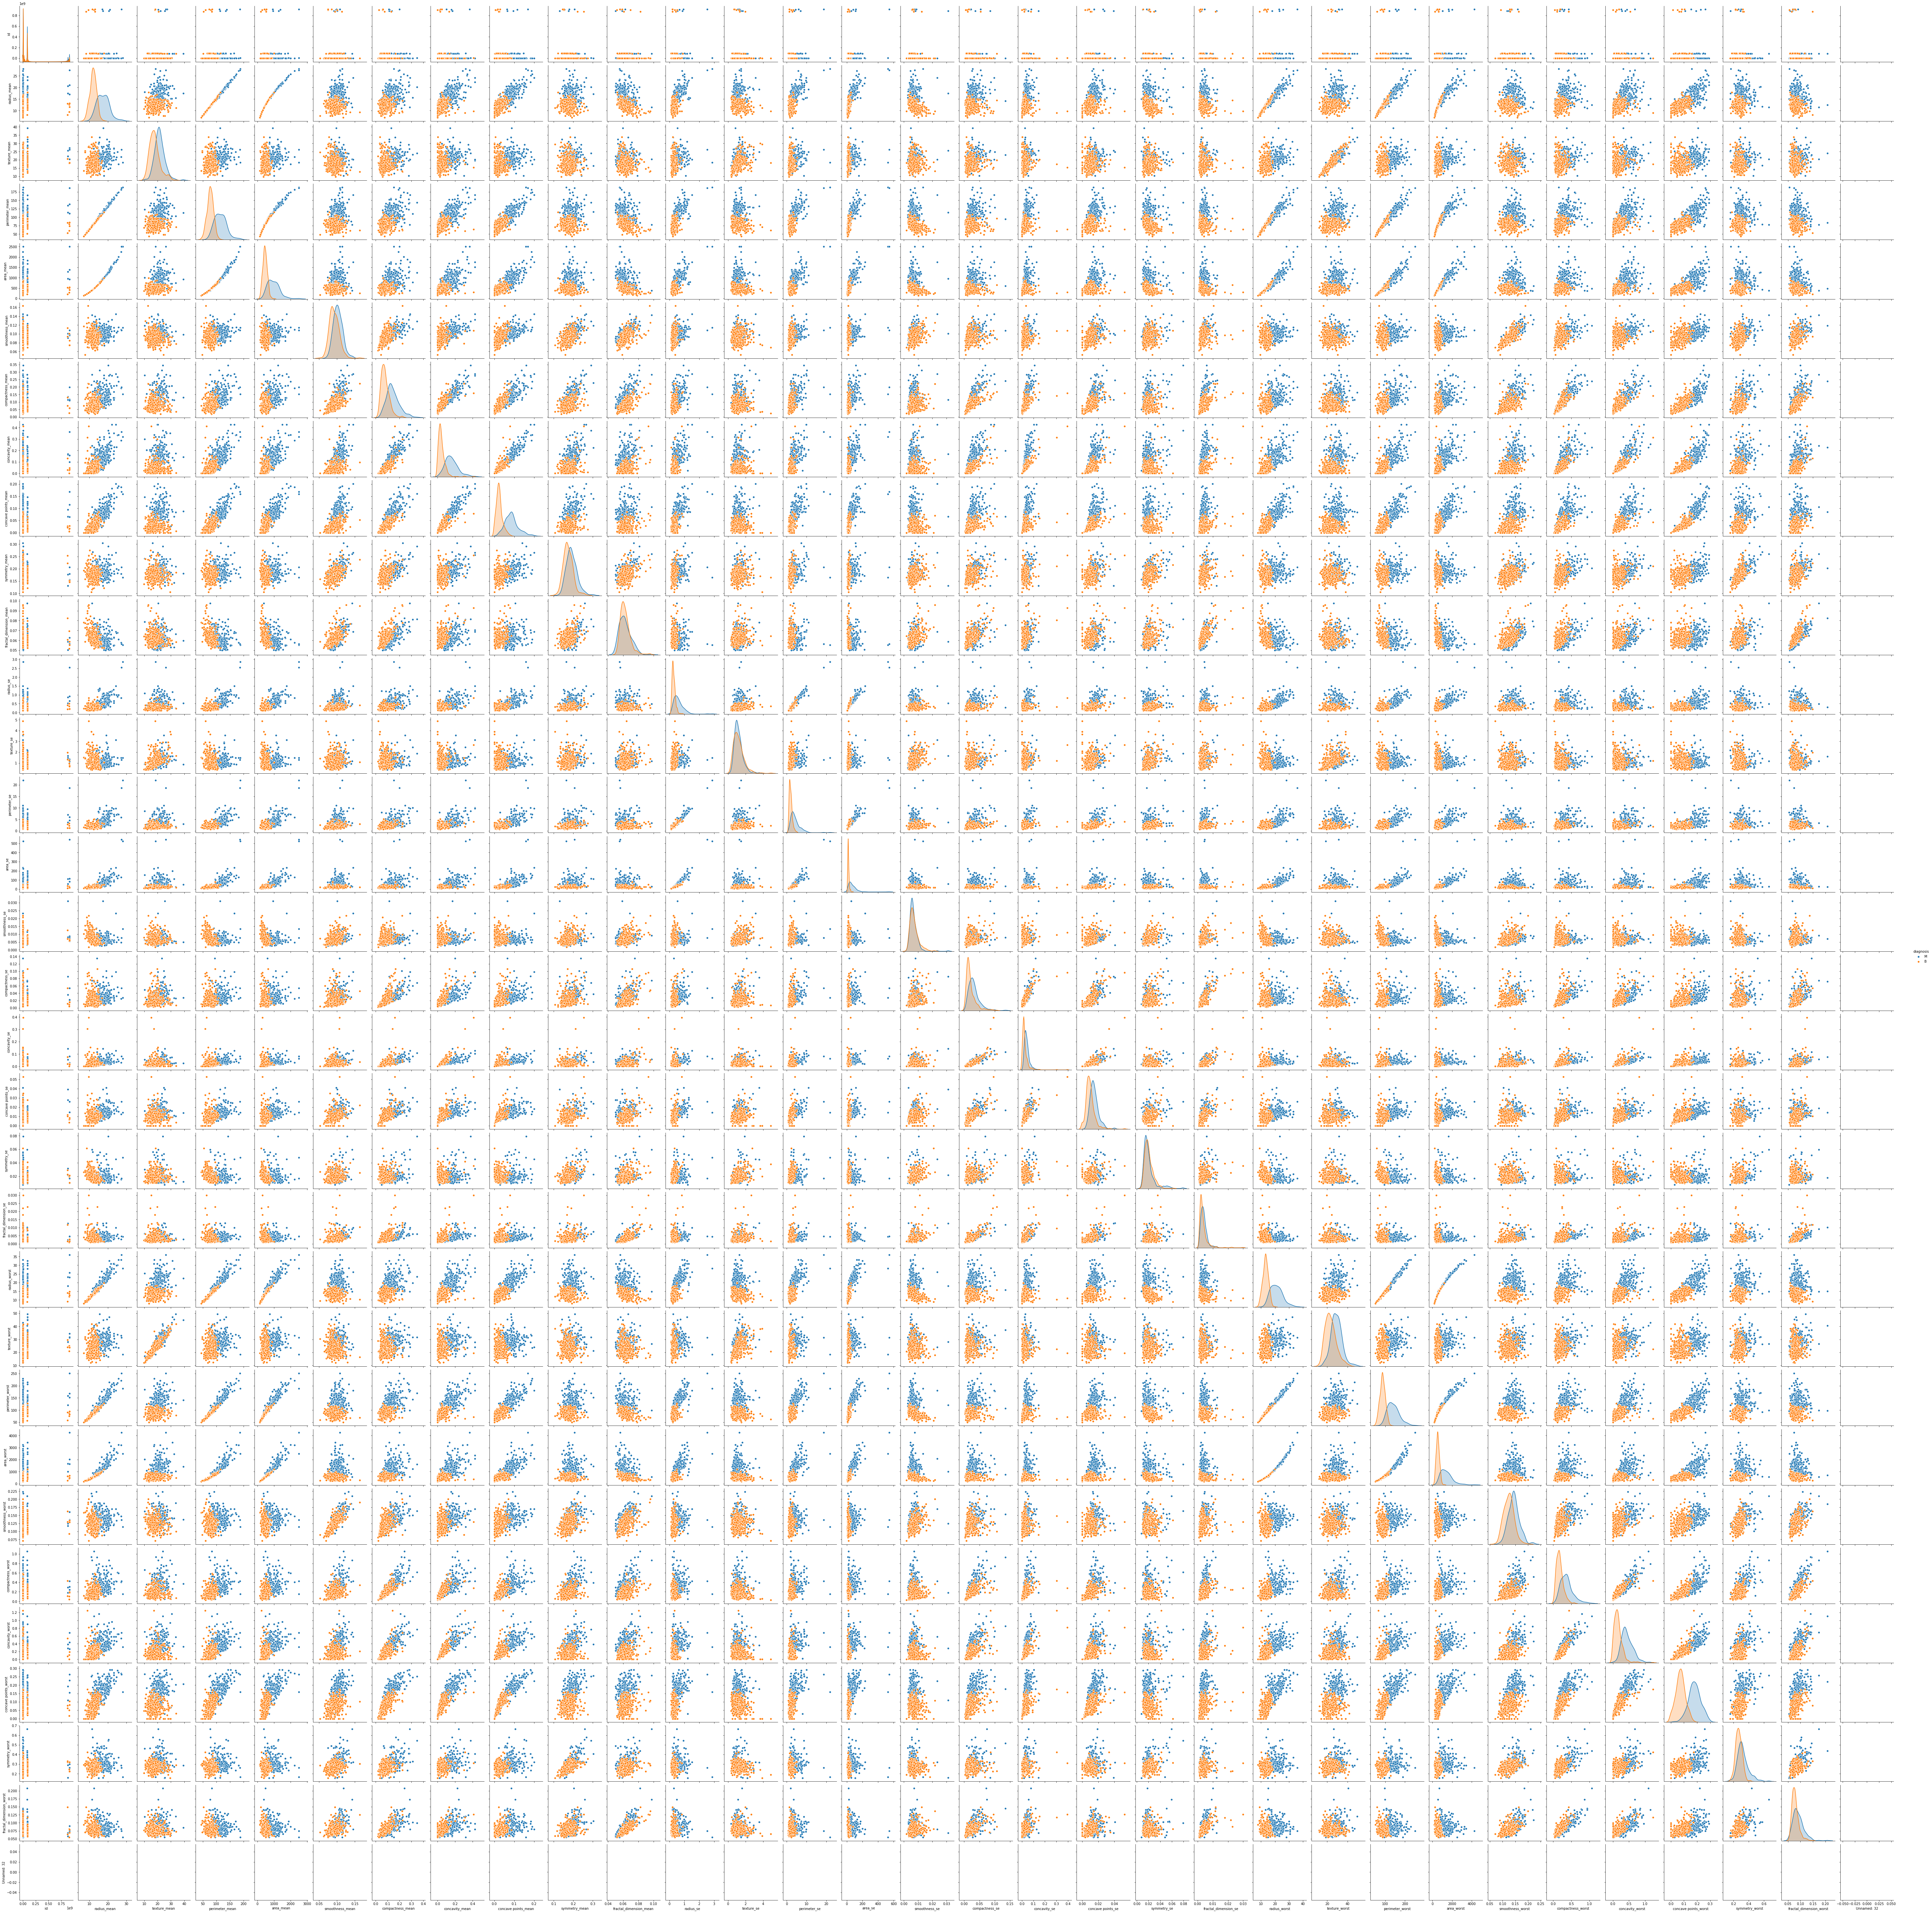

In [236]:
sns.pairplot(cancer,hue='diagnosis')

Если описать картину в целом, то мы видим, что по многим переменным классы M и B расходятся хорошо, то есть вероятнее всего классификатор на основе логистической регрессии на этих данных должен работать достаточно точно. Проверим это далее.

Сразу переведем значения M и B в 1 и 0 соответственно

In [175]:
cancer.diagnosis.replace(['M', 'B'], [1, 0], inplace=True)

In [176]:
cancer.head()

id  diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302          1        17.99         10.38          122.80     1001.0   
1    842517          1        20.57         17.77          132.90     1326.0   
2  84300903          1        19.69         21.25          130.00     1203.0   
3  84348301          1        11.42         20.38           77.58      386.1   
4  84358402          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  texture_worst  perimeter_worst  area_worst  smoothness_worst  \
0  ...          17.33           184.60      2019.0            0.1622   
1  ...          23.41           158.80      1956.0            0.1238   
2  ...          25.53           152.50      1709.0            0.1444   
3  ...          26.50            98.87       567.7            0.2098   
4  ...          16.67           152.20      1575.0            0.1374   

   compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
0             0.6656           0.7119                0.2654          0.4601   
1             0.1866           0.2416                0.1860          0.2750   
2             0.4245           0.4504                0.2430          0.3613   
3             0.8663           0.6869                0.2575          0.6638   
4             0.2050           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN  

[5 rows x 33 columns]

Для проверки наличия NA воспользуемся функцией isnull() и посчитаем количество NaN в каждой колонке.

In [177]:
cancer.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

Видим, что в колонке 'Unnamed: 32' у нас 569 NA, а всего в таблице...

In [231]:
cancer.shape

(569, 33)

Как раз 569 значений. То есть вся колонка полностью состоит из NA и мы точно можем от нее избавиться. Заодно удалим сразу и колонку, содержащую id, чтобы она не мешала для будущего предсказания

In [ ]:
new_cancer = cancer.drop([r'Unnamed: 32','id'],axis = 1)

Теперь обозначим, значение какой переменной мы будем предсказывать, а именно 'diagnosis' и также удалим данную колонку из датафрэйма

In [179]:
for_predict = new_cancer.diagnosis

In [180]:
new_cancer = new_cancer.drop(['diagnosis'],axis = 1)

Теперь нам необходимо разбить наш датасет на тренировочную и тестовую выборки, для этого воспользуемся функцией train_test_split из sklearn.model_selection, для тестовой выборки оставим 33%

In [206]:
cancer_train, cancer_test, predict_train, predict_test = train_test_split(new_cancer, for_predict, shuffle=True,test_size = 0.33, random_state = 42)

In [182]:
cancer_train.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
172        15.46         11.89          102.50      736.9          0.12570   
407        12.85         21.37           82.63      514.5          0.07551   
56         19.21         18.57          125.50     1152.0          0.10530   
497        12.47         17.31           80.45      480.1          0.08928   
301        12.46         19.89           80.43      471.3          0.08451   

     compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
172           0.15550         0.20320              0.10970         0.1966   
407           0.08316         0.06126              0.01867         0.1580   
56            0.12670         0.13230              0.08994         0.1917   
497           0.07630         0.03609              0.02369         0.1526   
301           0.10140         0.06830              0.03099         0.1781   

     fractal_dimension_mean  ...  radius_worst  texture_worst  \
172                 0.07069  ...         18.79          17.04   
407                 0.06114  ...         14.40          27.01   
56                  0.05961  ...         26.14          28.14   
497                 0.06046  ...         14.06          24.34   
301                 0.06249  ...         13.46          23.07   

     perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
172           125.00      1102.0           0.15310             0.3583   
407            91.63       645.8           0.09402             0.1936   
56            170.10      2145.0           0.16240             0.3511   
497            92.82       607.3           0.12760             0.2506   
301            88.13       551.3           0.10500             0.2158   

     concavity_worst  concave points_worst  symmetry_worst  \
172           0.5830               0.18270          0.3216   
407           0.1838               0.05601          0.2488   
56            0.3879               0.20910          0.3537   
497           0.2028               0.10530          0.3035   
301           0.1904               0.07625          0.2685   

     fractal_dimension_worst  
172                  0.10100  
407                  0.08151  
56                   0.08294  
497                  0.07661  
301                  0.07764  

[5 rows x 30 columns]

Пришло время обучить модель. Для этого создадим классификатор на основе логистической регрессии и передадим ему тренировочные данные.

In [207]:
LRC = LogisticRegression(random_state=0)
LRC.fit(cancer_train, predict_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Используем обученную модель для предсказания значений diagnosis и посмотрим, каковы получились метрики модели (precision,recall, f-score)

In [208]:
predictions = LRC.predict(cancer_test)
print(metrics.classification_report(predict_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       121
           1       0.94      0.94      0.94        67

   micro avg       0.96      0.96      0.96       188
   macro avg       0.95      0.95      0.95       188
weighted avg       0.96      0.96      0.96       188



Как мы видим, значения всех пааметров близки к 1, что говорит о том, что модель хорошо предсказывает значение диагноза. Если мы построим confusion matrix для тестовых данных, то увидим, что количество случаев, для которых диагноз определен ложно положительно или ложно отрицательно не велико, но тем не менее, учитывая, что наша модель должны предсказать серьезный диагноз, даже такие небольшие "погрешности" это уже не самый лучший результат.

In [202]:
print(metrics.confusion_matrix(predict_test, predictions))

[[117   4]
 [  4  63]]


Построим ROC-кривую

In [203]:
y_predicted_prob = LRC.predict_proba(cancer_test)

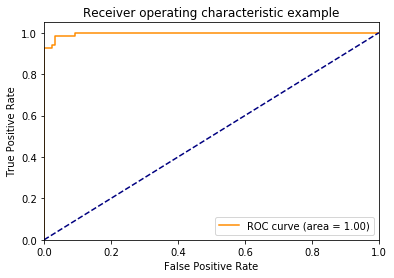

In [204]:
fpr, tpr, thresholds = roc_curve(predict_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Мы видим, что площадь под ROC кривой примерно равна единице, то есть наша модель работает очень хорошо и ложно-положительные классификации, ровно как ложно-отрицательные практически отсутстсвуют. Однако такие случаи все же есть, поэтому поработает над улучшением качества модели. 

На способность модели к обобщению и соответственно на меньший шанс переобученности часто влияет параметр регуляризации или C-параметр. Попробуем его изменить и посмотрим, как это влияет на качество модели.

In [221]:
from sklearn.metrics import accuracy_score,precision_score
C_param_range = [0.001,0.01,0.1,1,10,100]

acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy','Precision'])
acc_table['C_parameter'] = C_param_range

In [222]:
j = 0
for i in C_param_range:
    lr = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    lr.fit(cancer_train,predict_train)
    prediction = lr.predict(cancer_test)
    acc_table.iloc[j,1] = accuracy_score(predict_test,prediction)
    acc_table.iloc[j,2] = precision_score(predict_test,prediction)
    j += 1

In [223]:
print(acc_table)

   C_parameter  Accuracy Precision
0        0.001  0.973404         1
1        0.010  0.968085  0.984127
2        0.100  0.973404  0.969697
3        1.000  0.957447  0.940299
4       10.000  0.962766  0.941176
5      100.000  0.962766  0.928571


In [227]:
LRC_new = LogisticRegression(random_state=0,penalty = 'l2', C = 0.001)
LRC_new.fit(cancer_train, predict_train)
predictions = LRC_new.predict(cancer_test)

In [228]:
print(metrics.classification_report(predict_test, predictions))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       121
           1       1.00      0.93      0.96        67

   micro avg       0.97      0.97      0.97       188
   macro avg       0.98      0.96      0.97       188
weighted avg       0.97      0.97      0.97       188



Видим, что значения параметров precision и recall действительно стали выше. Теперь посмотрим, что с ROC-кривой

In [229]:
y_predicted_prob = LRC_new.predict_proba(cancer_test)

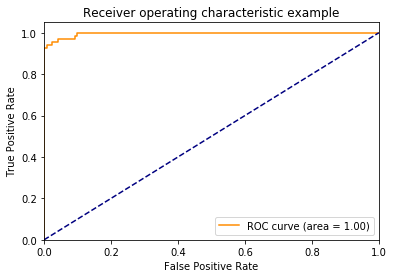

In [230]:
fpr, tpr, thresholds = roc_curve(predict_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Площадь под кривой также осталась близкой к наивысшему значению, то есть единице.
Но все же если мы посмотрим на значение Precision и Recall для каждого типа рака с новым значением c-parametr еещ раз, то увидим, что у нас снизилась вероятность ложно-положительно определить тип рака 1 (M), зато слегка повысилась вероятность пропустить его наличие, а также чуть возросла вероятность определить опухоль как 0(B). И на самом деле, в данном случае это говорит, что модель хоть немного, но ухудшилась, так как M соответсвует злокачественной, а B - доброкачественной форме. Так что, несмотря на то, что в среднем показатели Precision и Recall стали лучше, отталкиваясь от медицинского смысла модели - лучше она не стала. 